In [1]:
#reading an excel file of adult analysis data and producing/saving the following plots

In [2]:
data_path = '/home/tli_project/Desktop/Data/T4/neurons/output/New/all_px/'
save_path = '/home/tli_project/Desktop/Data/T4/neurons/output/figures_final/'
save_plots = True

In [3]:
import utils.datautils as datautils
from tqdm import tqdm
import os
from os import path
import re
import numpy as np
import pandas as pd
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import ruptures as rpt
from scipy.optimize import curve_fit

In [4]:
output_files = datautils.get_file_names(data_path, group_by='_', order=True, nested_files=False, criteria='.csv')

first 5 files
['/home/tli_project/Desktop/Data/T4/neurons/output/New/all_px/220209_P36_N2_sA.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/all_px/220209_P36_N1_sC.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/all_px/220127_P36_N1_sD.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/all_px/211121_P36.5_N3_sC.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/all_px/211121_P36.5_N2_sA.csv']


0.011505078465424494
0.031999676108972884


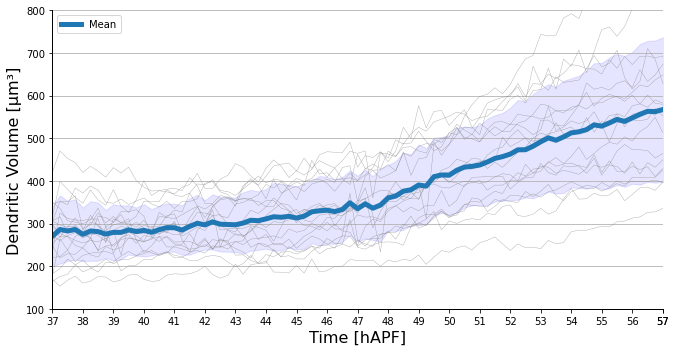

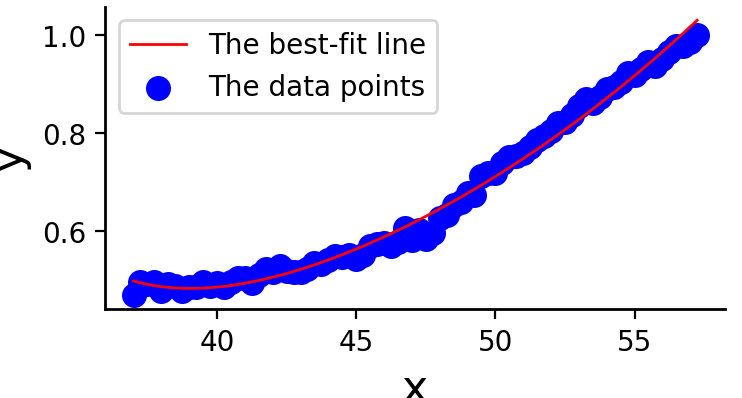

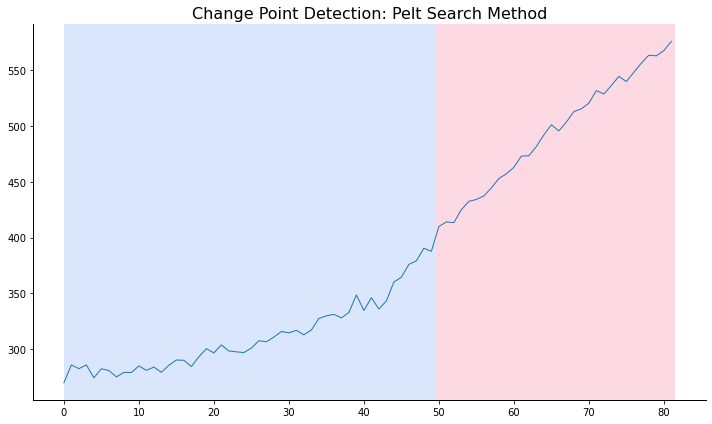

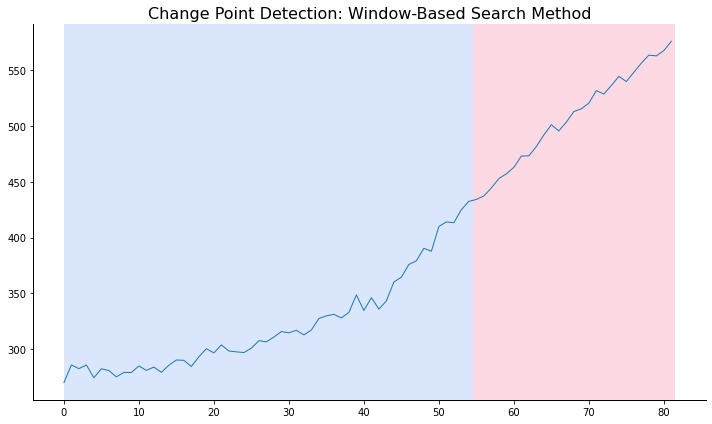

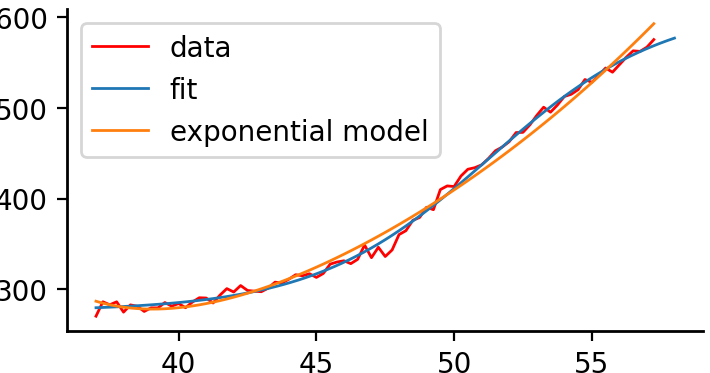

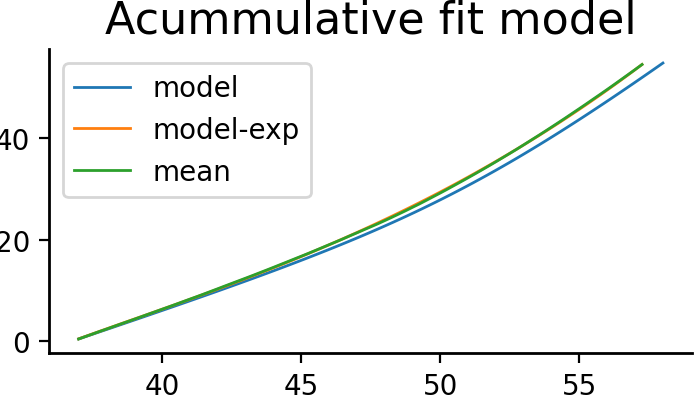

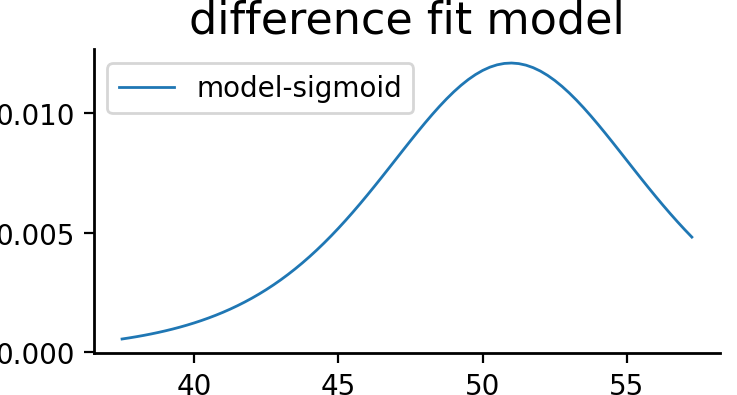

In [6]:
plot_col = 'volume'

timepoints = {'timepoint':np.arange(36,58,0.25)}
results = pd.DataFrame(timepoints)
#reading the specified column from each output file, and adding it to collective_results
for file in output_files:
    neu_name = os.path.basename(file[:file.find('.csv')])
    temp_df = pd.read_csv(file, sep=',', usecols = ['timepoint', plot_col])
    temp_df = temp_df.rename(columns={plot_col:neu_name})
    results = pd.merge(results, temp_df, on='timepoint')

test = results.copy()

fig, ax = plt.subplots(1)

#plotting individual neuron traces as grey faint lines
plt.plot(results.timepoint, results.loc[:,results.columns != 'timepoint'], c='grey', alpha=0.7, linewidth=0.4)

# calculating mean and std and plotting them
results_mean = results.loc[:,results.columns != 'timepoint'].mean(axis=1)
results_std = results.loc[:,results.columns != 'timepoint'].std(axis=1)
results['results_mean'] = results_mean
results['results_std'] = results_std

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

def func(x, a, b, c, d):
    return a * np.exp(b * x) + c * np.exp(d * x)

ydata = results.results_mean / max(results.results_mean)
p0 = [max(ydata), np.median(results.timepoint),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, results.timepoint, ydata,p0, method='lm')
# popt, pcov = curve_fit(func, results.timepoint, ydata)

L ,x0, k, b = popt
residuals = ydata - sigmoid(results.timepoint,L ,x0, k, b)
fres = sum( (residuals**2)/sigmoid(results.timepoint,L ,x0, k, b) ) # The chi-sqaure of your fit
print(fres)


x = np.linspace(37, 58, 81)
y = sigmoid(x, *popt)
limit = y.max() - (y.max() - y.min())/2
half_max = x[np.argwhere(y>limit)[0]]

plt.plot(results.timepoint, results_mean, linewidth=5, label='Mean')
# plt.plot(x,y*max(results.results_mean), label='model fit', c='r', linewidth=2, alpha=0.7)
# plt.axvline(half_max)


min_val = results_mean - 1*results_std
max_val = results_mean + 1*results_std
plt.fill_between(results['timepoint'], min_val, max_val, color='blue', alpha=.1)

plt.xlim(37,57)
x_range1 = list(np.arange(37,58,1))
x_range1.append(57)
plt.xticks(x_range1)

ax.set_ylim(100,800)
ax.yaxis.grid()

# ax.set_title('Dendritic volume over time')
ax.set_xlabel('Time [hAPF]')
ax.set_ylabel("Dendritic Volume [µm³]")

plt.legend()
plt.style.use('test.mplstyle')
plt_name = 'Fig2C_volume.pdf'
if save_plots:
    plt.savefig(save_path+plt_name)


x1 = np.linspace(0,4,82) # Example data
ydata = results.results_mean / max(results.results_mean)
p0 = [max(ydata), np.median(x1),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(func,x1,ydata,p0)

# print(popt) # This contains your three best fit parameters

p1 = popt[0] # This is your a
p2 = popt[1] # This is your b
p3 = popt[2] # This is your c
p4 = popt[3] # This is your d

residuals = ydata - func(x1,p1,p2,p3,p4)
fres = sum( (residuals**2)/func(x1,p1,p2,p3,p4) ) # The chi-sqaure of your fit
print(fres)

""" Now if you need to plot, perform the code below """
curvey = func(x1,p1,p2,p3,p4) # This is your y axis fit-line

fig, ax = plt.subplots(1)
plt.plot(results.timepoint, curvey, 'red', label='The best-fit line')
plt.scatter(results.timepoint,ydata, c='b',label='The data points')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')



points=np.array(results.results_mean)    
#RUPTURES PACKAGE
#Changepoint detection with the Pelt search method
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=10)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()


plt.plot(results.timepoint, results.results_mean, c='r', label='data')
plt.plot(x,y*max(results.results_mean), label='fit')
plt.plot(results.timepoint,curvey*max(results.results_mean),label='exponential model')
plt.legend(loc='best')


fig, ax = plt.subplots(1)
ax.plot(x, y.cumsum(), label='model')
ax.plot(results.timepoint, curvey.cumsum(), label='model-exp')
ax.plot(results.timepoint, ydata.cumsum(), label='mean')
plt.title('Acummulative fit model')
plt.legend()

fig, ax = plt.subplots(1)
ax.plot(results.timepoint[2:],np.diff(y), label='model-sigmoid')
# ax.plot(np.diff(curvey), label='model-exp')
# ax.plot(np.diff(ydata), label='mean')
plt.title('difference fit model')
plt.legend()

0.034435776181363446
0.06777001113293919


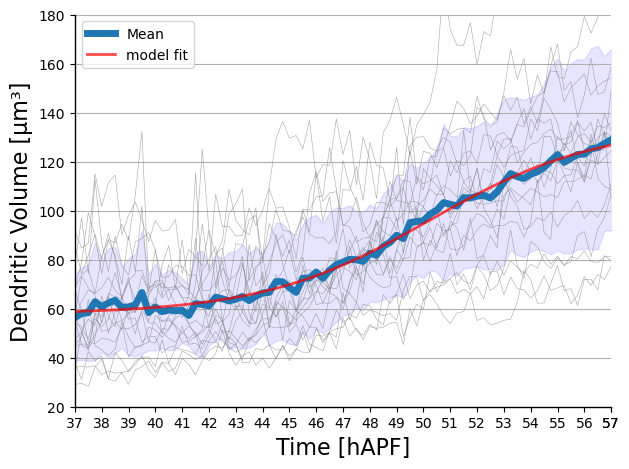

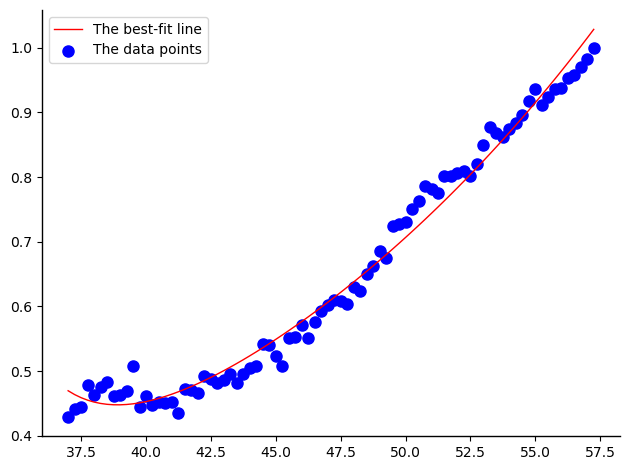

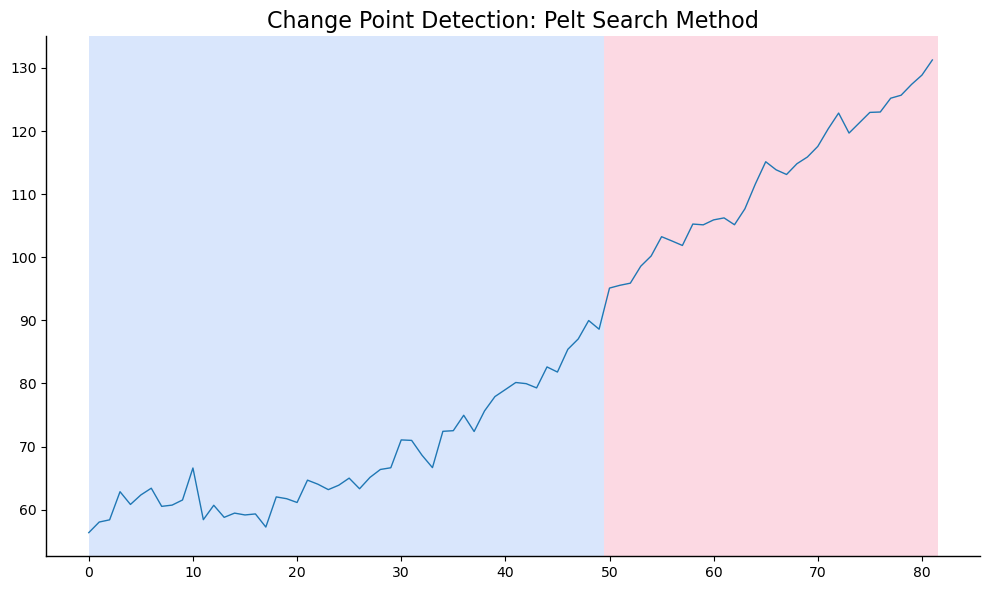

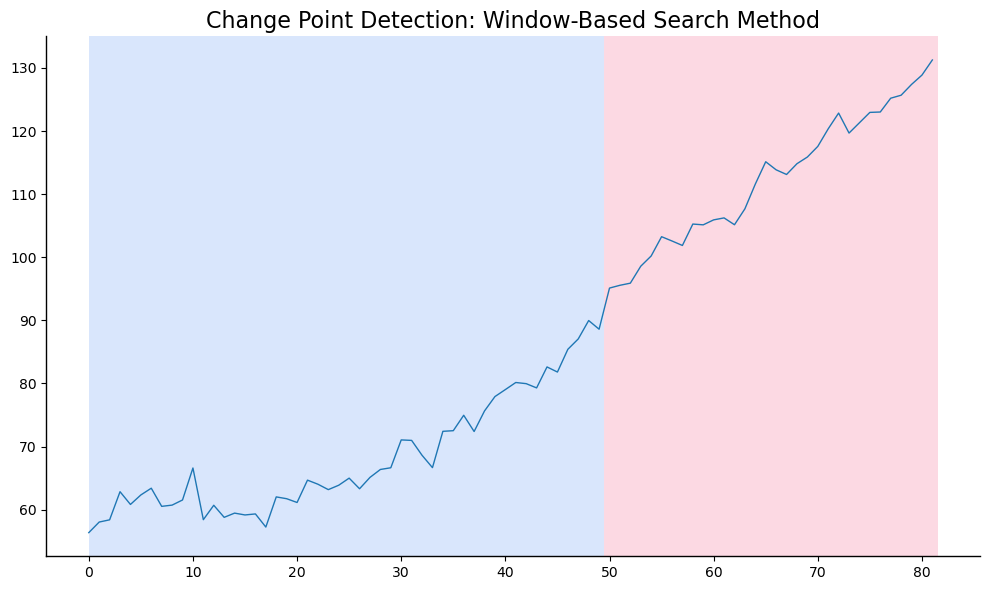

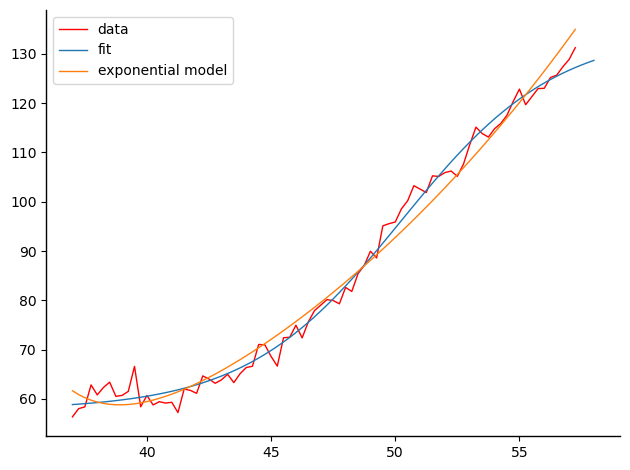

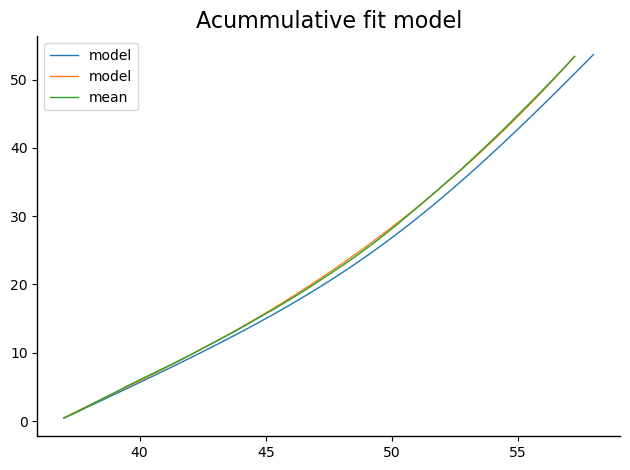

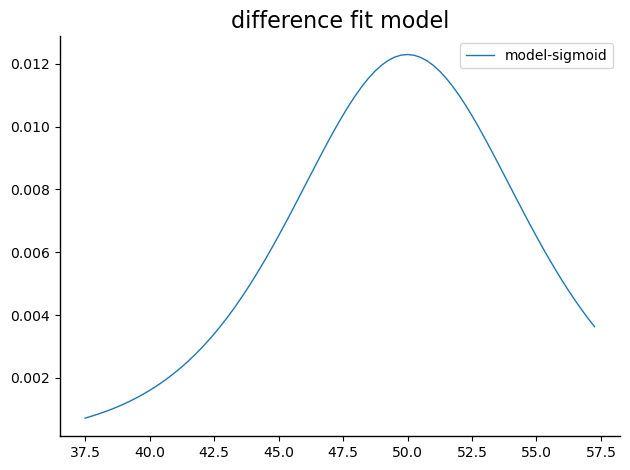

In [35]:
plot_col = 'area'

timepoints = {'timepoint':np.arange(36,58,0.25)}
results = pd.DataFrame(timepoints)
#reading the specified column from each output file, and adding it to collective_results
for file in output_files:
    neu_name = os.path.basename(file[:file.find('.csv')])
    temp_df = pd.read_csv(file, sep=',', usecols = ['timepoint', plot_col])
    temp_df = temp_df.rename(columns={plot_col:neu_name})
    results = pd.merge(results, temp_df, on='timepoint')

fig, ax = plt.subplots(1)

#plotting individual neuron traces as grey faint lines
plt.plot(results.timepoint, results.loc[:,results.columns != 'timepoint'], c='grey', alpha=0.7, linewidth=0.4)

# calculating mean and std and plotting them
results_mean = results.loc[:,results.columns != 'timepoint'].mean(axis=1)
results_std = results.loc[:,results.columns != 'timepoint'].std(axis=1)
results['results_mean'] = results_mean
results['results_std'] = results_std

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

def func(x, a, b, c, d):
    return a * np.exp(b * x) + c * np.exp(d * x)

ydata = results.results_mean / max(results.results_mean)
p0 = [max(ydata), np.median(results.timepoint),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, results.timepoint, ydata,p0, method='lm')
# popt, pcov = curve_fit(func, results.timepoint, ydata)

L ,x0, k, b = popt
residuals = ydata - sigmoid(results.timepoint,L ,x0, k, b)
fres = sum( (residuals**2)/sigmoid(results.timepoint,L ,x0, k, b) ) # The chi-sqaure of your fit
print(fres)


x = np.linspace(37, 58, 81)
y = sigmoid(x, *popt)
limit = y.max() - (y.max() - y.min())/2
half_max = x[np.argwhere(y>limit)[0]]

plt.plot(results.timepoint, results_mean, linewidth=5, label='Mean')
plt.plot(x,y*max(results.results_mean), label='model fit', c='r', linewidth=2, alpha=0.7)
# plt.axvline(half_max)


min_val = results_mean - 1*results_std
max_val = results_mean + 1*results_std
plt.fill_between(results['timepoint'], min_val, max_val, color='blue', alpha=.1)

plt.xlim(37,57)
x_range1 = list(np.arange(37,58,1))
x_range1.append(57)
plt.xticks(x_range1)

ax.set_ylim(20,180)
ax.yaxis.grid()

# ax.set_title('Dendritic volume over time')
ax.set_xlabel('Time [hAPF]')
ax.set_ylabel("Dendritic Volume [µm³]")

plt.legend()
plt.style.use('test.mplstyle')
plt_name = 'Fig2C_volume.pdf'
if save_plots:
    plt.savefig(save_path+plt_name)



x1 = np.linspace(0,4,82) # Example data
ydata = results.results_mean / max(results.results_mean)
p0 = [max(ydata), np.median(x1),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(func,x1,ydata,p0)

# print(popt) # This contains your three best fit parameters

p1 = popt[0] # This is your a
p2 = popt[1] # This is your b
p3 = popt[2] # This is your c
p4 = popt[3] # This is your d

residuals = ydata - func(x1,p1,p2,p3,p4)
fres = sum( (residuals**2)/func(x1,p1,p2,p3,p4) ) # The chi-sqaure of your fit
print(fres)

""" Now if you need to plot, perform the code below """
curvey = func(x1,p1,p2,p3,p4) # This is your y axis fit-line

fig, ax = plt.subplots(1)
plt.plot(results.timepoint, curvey, 'red', label='The best-fit line')
plt.scatter(results.timepoint,ydata, c='b',label='The data points')
plt.legend(loc='best')



points=np.array(results.results_mean)    
#RUPTURES PACKAGE
#Changepoint detection with the Pelt search method
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=10)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()


plt.plot(results.timepoint, results.results_mean, c='r', label='data')
plt.plot(x,y*max(results.results_mean), label='fit')
plt.plot(results.timepoint,curvey*max(results.results_mean),label='exponential model')
plt.legend(loc='best')


fig, ax = plt.subplots(1)
ax.plot(x, y.cumsum(), label='model')
ax.plot(results.timepoint, curvey.cumsum(), label='model')
ax.plot(results.timepoint, ydata.cumsum(), label='mean')
plt.title('Acummulative fit model')
plt.legend()

fig, ax = plt.subplots(1)
ax.plot(results.timepoint[2:],np.diff(y), label='model-sigmoid')
# ax.plot(np.diff(curvey), label='model')
# ax.plot(results.timepoint[1:], np.diff(ydata), label='mean')
plt.title('difference fit model')
plt.legend()

0.01977696553400222
0.03341694918265283


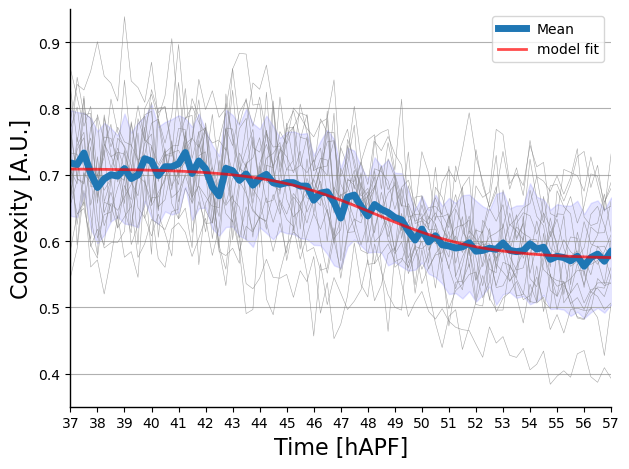

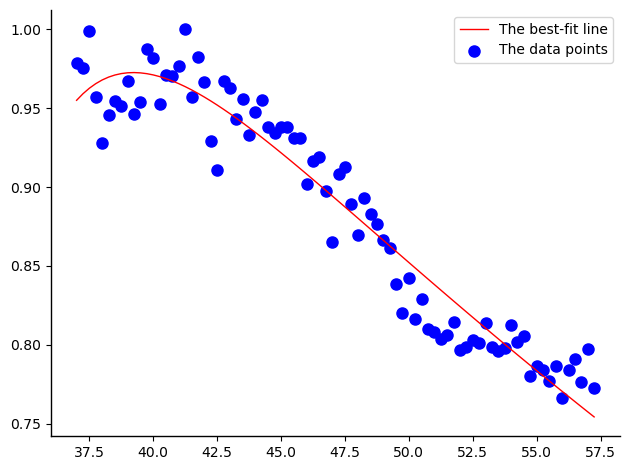

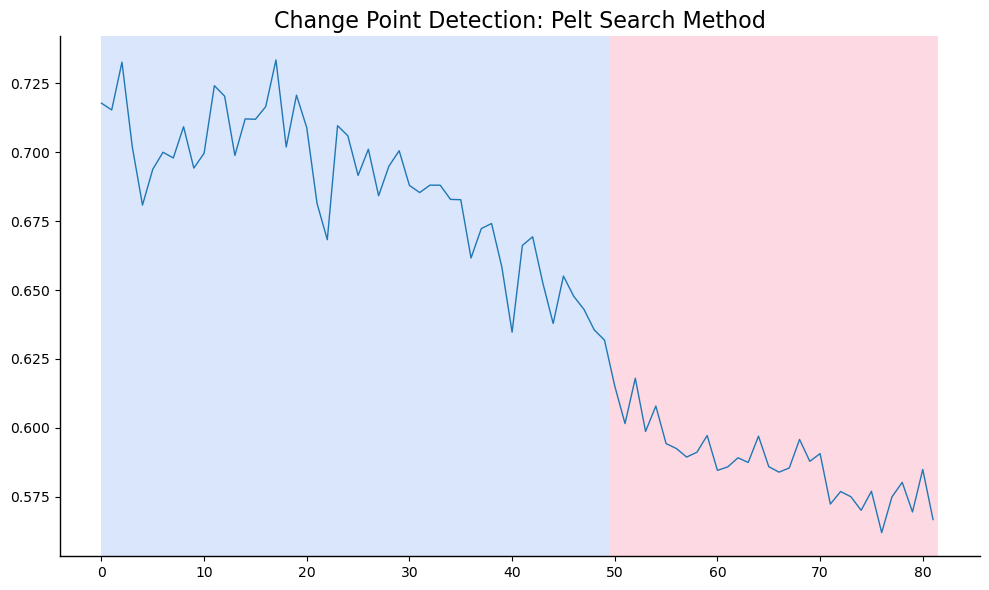

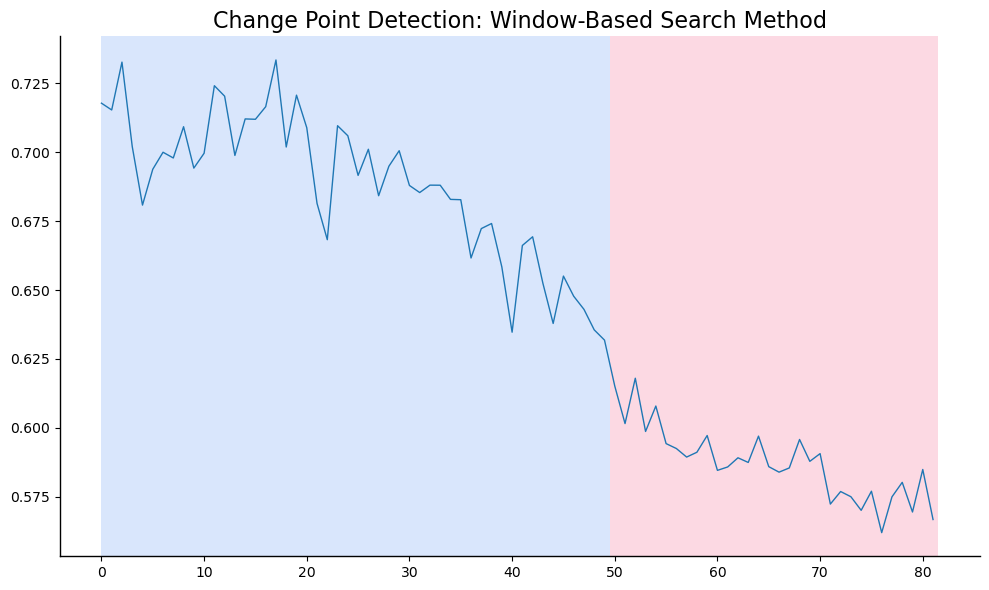

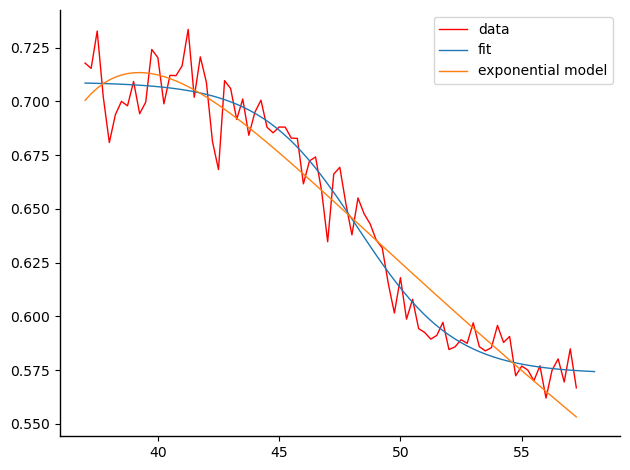

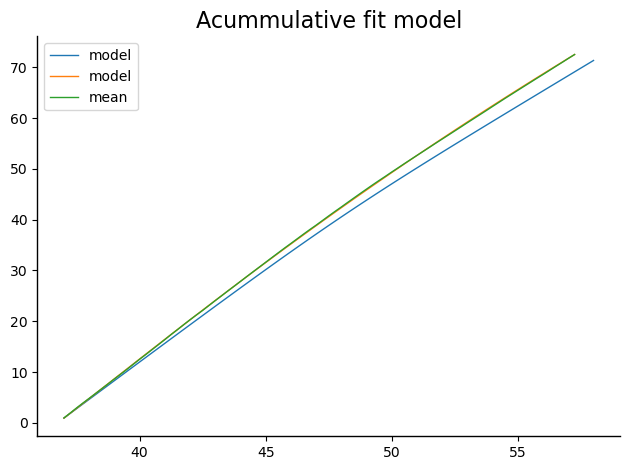

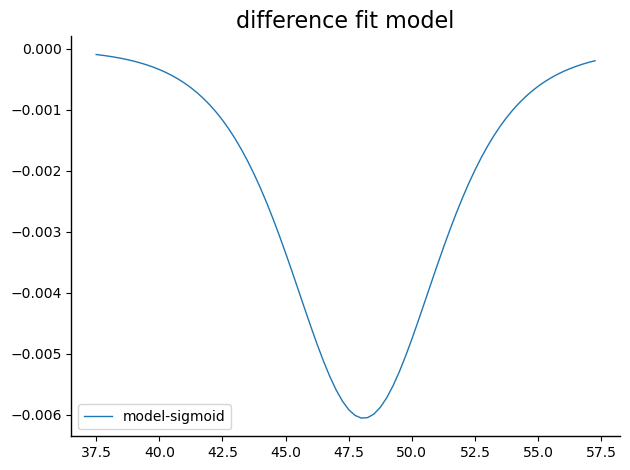

In [36]:
plot_col = 'convexity_2D'

timepoints = {'timepoint':np.arange(36,58,0.25)}
results = pd.DataFrame(timepoints)
#reading the specified column from each output file, and adding it to collective_results
for file in output_files:
    neu_name = os.path.basename(file[:file.find('.csv')])
    temp_df = pd.read_csv(file, sep=',', usecols = ['timepoint', plot_col])
    temp_df = temp_df.rename(columns={plot_col:neu_name})
    results = pd.merge(results, temp_df, on='timepoint')

fig, ax = plt.subplots(1)

#plotting individual neuron traces as grey faint lines
plt.plot(results.timepoint, results.loc[:,results.columns != 'timepoint'], c='grey', alpha=0.7, linewidth=0.4)

# calculating mean and std and plotting them
results_mean = results.loc[:,results.columns != 'timepoint'].mean(axis=1)
results_std = results.loc[:,results.columns != 'timepoint'].std(axis=1)
results['results_mean'] = results_mean
results['results_std'] = results_std

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def func(x, a, b, c, d):
    return a * np.exp(-b * x) + c * np.exp(-d * x)


ydata = results.results_mean / max(results.results_mean)
p0 = [max(ydata), np.median(results.timepoint),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, results.timepoint, ydata,p0, method='lm')

L ,x0, k, b = popt
residuals = ydata - sigmoid(results.timepoint,L ,x0, k, b)
fres = sum( (residuals**2)/sigmoid(results.timepoint,L ,x0, k, b) ) # The chi-sqaure of your fit
print(fres)

x = np.linspace(37, 58, 81)
y = sigmoid(x, *popt)

limit = y.max() - (y.max() - y.min())/2
half_max = x[np.argwhere(y<limit)[0]]

plt.plot(results.timepoint, results_mean, linewidth=5, label='Mean')
plt.plot(x,y*max(results.results_mean), label='model fit', c='r', linewidth=2, alpha=0.7)
# plt.axvline(half_max)

min_val = results_mean - 1*results_std
max_val = results_mean + 1*results_std
plt.fill_between(results['timepoint'], min_val, max_val, color='blue', alpha=.1)

plt.xlim(37,57)
x_range1 = list(np.arange(37,58,1))
# x_range1.append(57)
plt.xticks(x_range1)

ax.yaxis.grid()
ax.set_ylim(.35,.95)


# ax.set_title('Dendritic Convexity over time')
ax.set_xlabel('Time [hAPF]')
ax.set_ylabel("Convexity [A.U.]")
plt.legend()

plt.style.use('test.mplstyle')
plt_name = 'Fig2F_Convexity.pdf'
if save_plots:
    plt.savefig(save_path+plt_name)


x1 = np.linspace(0,4,82) # Example data
ydata = results.results_mean / max(results.results_mean)
p0 = [max(ydata), np.median(x1),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(func,x1,ydata,p0)

# print(popt) # This contains your three best fit parameters

p1 = popt[0] # This is your a
p2 = popt[1] # This is your b
p3 = popt[2] # This is your c
p4 = popt[3] # This is your d

residuals = ydata - func(x1,p1,p2,p3,p4)
fres = sum( (residuals**2)/func(x1,p1,p2,p3,p4) ) # The chi-sqaure of your fit
print(fres)

""" Now if you need to plot, perform the code below """
curvey = func(x1,p1,p2,p3,p4) # This is your y axis fit-line

fig, ax = plt.subplots(1)
plt.plot(results.timepoint, curvey, 'red', label='The best-fit line')
plt.scatter(results.timepoint,ydata, c='b',label='The data points')
plt.legend(loc='best')

points=np.array(results.results_mean)    
#RUPTURES PACKAGE
#Changepoint detection with the Pelt search method
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=10)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()


plt.plot(results.timepoint, results.results_mean, c='r', label='data')
plt.plot(x,y*max(results.results_mean), label='fit')
plt.plot(results.timepoint,curvey*max(results.results_mean),label='exponential model')
plt.legend(loc='best')


fig, ax = plt.subplots(1)
ax.plot(x, y.cumsum(), label='model')
ax.plot(results.timepoint, curvey.cumsum(), label='model')
ax.plot(results.timepoint, ydata.cumsum(), label='mean')
plt.title('Acummulative fit model')
plt.legend()

fig, ax = plt.subplots(1)
ax.plot(results.timepoint[2:],np.diff(y), label='model-sigmoid')
# ax.plot(np.diff(curvey), label='model')
# ax.plot(results.timepoint[1:], np.diff(ydata), label='mean')
plt.title('difference fit model')
plt.legend()